In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, sosfiltfilt, filtfilt, freqz
from scipy import signal
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d,gaussian_filter
import pickle
from skimage import io, filters
import glob
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph
from brainsss.brain_utils import warp_raw
from brainsss.utils import save_qc_png, save_h5_chunks

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [9]:
fly_num = 'fly_208'
func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/'
# load_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco.h5')
load_directory = os.path.join(func_path, 'func_0/moco/functional_channel_2_moco.h5')
# save_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco_highpass_test.h5')
# load_directory = os.path.join(func_path, 'func_0/functional_channel_2_moco_zscore.h5')
warp_directory = os.path.join(func_path,'warp/warp_nonbg_test.h5')
# load_dir = os.path.join(warp_directory,  'test.h5')

In [3]:
%%time
with h5py.File(load_directory, 'r') as hf:
        data = hf['data'][:]
        dims = np.shape(data)

        print("Data shape is {}".format(dims))  

Data shape is (256, 128, 49, 3384)
CPU times: user 3.49 s, sys: 20 s, total: 23.5 s
Wall time: 16min 56s


In [4]:
data=data[...,:500]

In [5]:
np.shape(data)

(256, 128, 49, 500)

In [6]:
data_norm=(data-np.min(data))/(np.max(data)-np.min(data))

In [7]:
fixed = brainsss.load_fda_meanbrain()

In [8]:
%%time
#Warp the brain
warped = warp_raw(data=data_norm, stepsize=100, fixed=fixed, func_path=func_path)
print("Warped brain shape is {}".format(np.shape(warped)))

Warped brain shape is (314, 146, 91, 500)
CPU times: user 6min 58s, sys: 44.8 s, total: 7min 42s
Wall time: 3min 40s


In [10]:
save_h5_chunks(warp_directory, warped, stepsize=100)

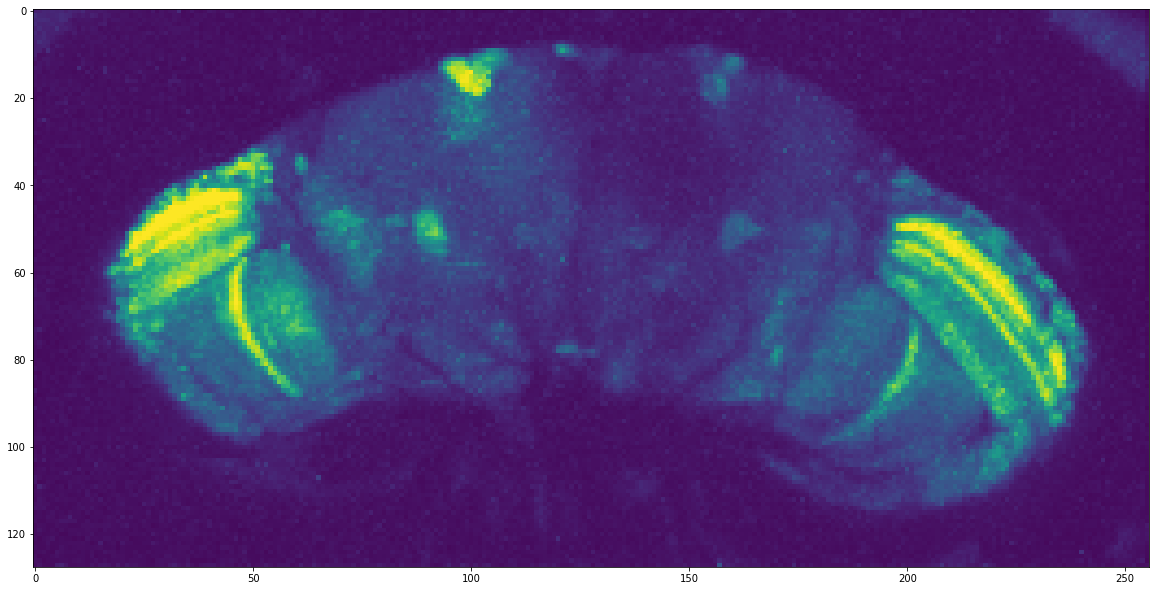

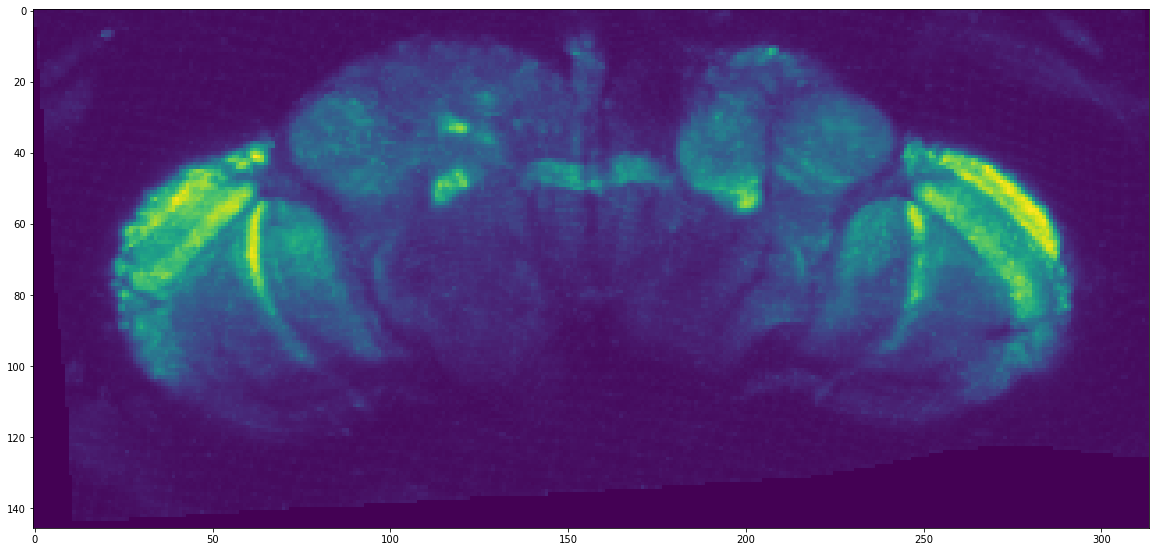

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(np.nanmax(data[:,:,20,:], axis=-1).T)
plt.figure(figsize=(20,20))
plt.imshow(np.nanmax(warped[:,:,20,:], axis=-1).T)

In [ ]:
class BgRemover3D:
    def __init__(self, img_path, save_path, half_wid=25):
        self.path = img_path
        self.save = save_path
        self.half_wid = half_wid
        # self.img shoud have dimension x, y, z, t here, x is along the line scan direction
        if '.nii' in img_path:
            self.img = np.asarray(nib.load(img_path).get_data().squeeze(), dtype='float32')
        elif '.h5' in img_path:
            with h5py.File(img_path, "r") as f:
                self.img = f['data'][:]
        else:
            print('format not supported!')
        self.make_savedir()

    def make_savedir(self):
        working_dir = self.save
        saving_dir = os.path.join(working_dir, 'background_subtraction')
        if not os.path.exists(saving_dir):
            os.mkdir(saving_dir)
        self.saving_dir = saving_dir
        self.file_head = os.path.basename(self.path).split('.')[0]

    def draw_bg(self):
        half_wid = self.half_wid
        wid = 2*half_wid
        kernel = np.ones(wid)/wid
        template = np.mean(self.img, axis=-1)
        template = np.moveaxis(template, (0, 2), (2, 0))
        bg_ind = []
        for patch in template:
            bg_ind_tmp = []
            for line in patch:
                tmp = np.convolve(line, kernel, 'valid')
                bg_center = np.argmin(tmp) + half_wid
                bg_ind_tmp.append([bg_center-half_wid, bg_center+half_wid])
            bg_ind.append(bg_ind_tmp)

        self.bg_ind = bg_ind

    def show_bg(self):
        bg_ind = self.bg_ind
        show_bg = np.mean(self.img, axis=-1)
        mv = np.round(np.max(show_bg))
        show_bg = np.moveaxis(show_bg, (0, 2), (2, 0))
        for i in range(show_bg.shape[0]):
            for j in range(show_bg.shape[1]):
                show_bg[i, j, bg_ind[i][j][0]:bg_ind[i][j][1]] = mv

        save_name = os.path.join(self.saving_dir, self.file_head+'_bg_selection.tif')
        io.imsave(save_name, np.round(show_bg).astype('int16'))


    def remove_bg(self, offset=300):
        bg_ind = self.bg_ind
        img = np.moveaxis(self.img, (0,1,2,3), (3,1,2,0))
        out = np.zeros_like(img)
        for ind_y in range(img.shape[1]):
            for ind_z in range(img.shape[2]):
                patch = img[:, ind_y, ind_z, :]
                bg_patch = img[:, ind_y, ind_z, bg_ind[ind_z][ind_y][0]:bg_ind[ind_z][ind_y][1]]
                bg = bg_patch.mean(axis=-1)
                patch = patch-bg[None].T
                out[:, ind_y, ind_z, :] = patch
        self.out = np.moveaxis(out, (0,1,2,3), (3,1,2,0))

    def show_spectrum(self, fs=180):
        half_wid = 5
        half_y = 15 
        kernel2d = np.ones((half_wid*2, half_y*2))/(4*half_wid*half_y)
        conv_template = signal.convolve2d(self.img.mean(-1).mean(-1), kernel2d, boundary='symm', mode='valid')
        test_x, test_y = np.unravel_index(np.argmin(conv_template), conv_template.shape)
        test_x += half_wid
        test_y += half_y

        test_patch = self.img[test_x-half_wid:test_x+half_wid, test_y-half_y:test_y+half_y, :, :]
        test = test_patch.mean(axis=(0,1))
        test = test.flatten(order='F') 
        test = (test-test.mean())/test.std()
        f, Pxx_den = signal.periodogram(test, fs)
        plt.semilogy(f, Pxx_den)
        plt.ylim([1e-7, 1000])
        plt.savefig(os.path.join(self.saving_dir, self.file_head+'_before_removal.png'))
        plt.close()

        test_patch = self.out[test_x-half_wid:test_x+half_wid, test_y-half_y:test_y+half_y, :, :]
        test = test_patch.mean(axis=(0,1))
        test = test.flatten(order='F') 
        test = (test-test.mean())/test.std()
        f, Pxx_den = signal.periodogram(test, fs)
        plt.semilogy(f, Pxx_den)
        plt.ylim([1e-7, 1000])
        plt.savefig(os.path.join(self.saving_dir, self.file_head+'_after_removal.png'))
        plt.close()

    def save_out(self):
        assert self.img.shape == self.out.shape
        if '.nii' in self.path:
            save_name = os.path.join(self.saving_dir, self.file_head+'_cleaned.nii')
            nib.Nifti1Image(np.round(self.out).astype('int16'), np.eye(4)).to_filename(save_name)
        elif '.h5' in self.path:
            save_name = os.path.join(self.saving_dir, self.file_head+'.h5')
            with h5py.File(save_name, "w") as data_file:
                data_file.create_dataset("data", data=np.round(self.out).astype('int16'))
